<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Agent/blob/main/autogen/02-MultiModal_0311.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "autogen-ext[openai]"

In [ ]:
!!pip install autogen-agentchat

In [ ]:
!pip install mcp

In [ ]:
!pip install json_schema_to_pydantic

In [1]:
from google.colab import userdata
import openai
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
openai.api_key  = os.environ["OPENAI_API_KEY"]

In [4]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [7]:
# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

In [5]:
async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print(response.chat_message)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=61, completion_tokens=16), metadata={}, content=[FunctionCall(id='call_ZBeBofOovjxhgm4WYlIsJTFk', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_ZBeBofOovjxhgm4WYlIsJTFk', is_error=False)], type='ToolCallExecutionEvent')]
source='assistant' models_usage=None metadata={} content='AutoGen is a programming framework for building multi-agent applications.' type='ToolCallSummaryMessage'



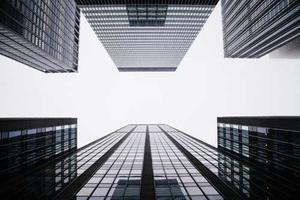

In [5]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

In [8]:
# Use asyncio.run(...) when running in a script.
response = await agent.on_messages([multi_modal_message], CancellationToken())
print(response.chat_message.content)

The image shows a view of tall skyscrapers from below, looking upwards. The buildings are modern with glass windows, creating a symmetrical and geometric perspective as the lines of the buildings converge towards the sky. The sky is overcast, giving a contrast to the darker building structures.


Streaming Messages

In [9]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.on_messages_stream(
    #     [TextMessage(content="Find information on AutoGen", source="user")],
    #     cancellation_token=CancellationToken(),
    # ):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.on_messages_stream(
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        ),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- assistant ----------
[FunctionCall(id='call_mNGn0pmYvDuQojwPL1PSJYS4', arguments='{"query":"AutoGen"}', name='web_search')]
[Prompt tokens: 391, Completion tokens: 16]
---------- assistant ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_mNGn0pmYvDuQojwPL1PSJYS4', is_error=False)]
---------- assistant ----------
AutoGen is a programming framework for building multi-agent applications.
---------- Summary ----------
Number of inner messages: 2
Total prompt tokens: 391
Total completion tokens: 16
Duration: 1.59 seconds


In [10]:
from autogen_core.tools import FunctionTool


# Define a tool using a Python function.
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# This step is automatically performed inside the AssistantAgent if the tool is a Python function.
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_messages call.
web_search_function_tool.schema

{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
tools = await mcp_server_tools(fetch_mcp_server)

# Create an agent that can use the fetch tool.
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)  # type: ignore

# Let the agent fetch the content of a URL and summarize it.
result = await agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
print(result.messages[-1].content)

In [ ]:
from autogen_core.tools import FunctionTool


# Define a tool using a Python function.
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# This step is automatically performed inside the AssistantAgent if the tool is a Python function.
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_messages call.
web_search_function_tool.schema

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
tools = await mcp_server_tools(fetch_mcp_server)

# Create an agent that can use the fetch tool.
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)  # type: ignore

# Let the agent fetch the content of a URL and summarize it.
result = await agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
print(result.messages[-1].content)

In [ ]:
import pandas as pd
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_experimental.tools.python.tool import PythonAstREPLTool

df = pd.read_csv("https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv")
tool = LangChainToolAdapter(PythonAstREPLTool(locals={"df": df}))
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(
    "assistant", tools=[tool], model_client=model_client, system_message="Use the `df` variable to access the dataset."
)
await Console(
    agent.on_messages_stream(
        [TextMessage(content="What's the average age of the passengers?", source="user")], CancellationToken()
    ),
    output_stats=True,
)